Trabajamos con el feature ccbd_diameter
y las confusoras 'ccbd_qa', 'age' y gender

In [48]:
# !pip install -q xgboost

In [49]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [50]:
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans 

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression # sci-kit learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [53]:
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, ConfusionMatrixDisplay # Accuracy metrics 

In [54]:
import pandas as pd
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)
def load_data_demo(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_demog.csv")
    return pd.read_csv(csv_path)

In [55]:
# Cargar DataFrame
df = load_data_prep()
df_dem = load_data_demo()
df1 = df.merge(df_dem, on="cod", how="left") # unimos las tablas con indice en "cod" y df_dem es incluida a la tabla df


In [56]:
# Especificar las variables predictoras y la variable objetivo
predictors = ['ccbd_qa', 'age', 'ccbd_diameter']  # 'gender' se eliminará temporalmente para la codificación one-hot
outcome = 'label'
 # obtenemos la mariz binaria

In [57]:
# Codificación One-Hot para la variable 'gender'
df1 = pd.get_dummies(df1, columns=['gender'])
x_simple = df1[predictors + ["gender_F","gender_M"]]
my_r = x_simple.corr(method="spearman")
print(my_r)

                ccbd_qa       age  ccbd_diameter  gender_F  gender_M
ccbd_qa        1.000000 -0.115373       0.159116  0.110405 -0.110405
age           -0.115373  1.000000      -0.237001  0.114119 -0.114119
ccbd_diameter  0.159116 -0.237001       1.000000 -0.120694  0.120694
gender_F       0.110405  0.114119      -0.120694  1.000000 -1.000000
gender_M      -0.110405 -0.114119       0.120694 -1.000000  1.000000


In [58]:
# Partición en train y test

X_train, X_test, y_train, y_test = train_test_split(df1[predictors + ['gender_F', 'gender_M']], df[outcome], test_size=0.2, random_state=99)

In [59]:
X_= X_train.reset_index()
y_= y_train.reset_index()
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [60]:
pipelines = {
    'mnb':make_pipeline(MinMaxScaler(), MultinomialNB()),
    'lr':make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),
    'xgb':make_pipeline(StandardScaler(), xgb.XGBClassifier()),
    'knn':make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)),
    'svm':make_pipeline(StandardScaler(), LinearSVC(C=0.0001)),
    'clf':make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_split=10,max_depth=3)),
    'bglr':make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'bg':make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'adb':make_pipeline(StandardScaler(), AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, bootstrap = True, random_state=42, max_depth=3)),
    'evc':make_pipeline(MinMaxScaler(), VotingClassifier(estimators=[('mnb',MultinomialNB()),('lr', LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),('rf',RandomForestClassifier(n_estimators=300,max_depth=3)),('svm',LinearSVC(C=0.0001))]))}


In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_train_) # encuentro los parametros para el escaleo
            #X_train_ = scaler.transform(X_train_) # aplico la transformacion

            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_test_) # encuentro los parametros para el escaleo
            #X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')
      # fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      # auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

      # auc_values.append(auc_test)
      # scores = np.concatenate((scores,probas_test[:,1]),axis=0)
      # indices = np.concatenate((indices,test_index),axis=0)
      fit_models[algo] = model

mnb ac-sc: 0.5 pr-sc: 0.5 rc-sc: 0.5
mnb ac-sc: 0.667 pr-sc: 0.689 rc-sc: 0.667
mnb ac-sc: 0.667 pr-sc: 0.673 rc-sc: 0.667
mnb ac-sc: 0.533 pr-sc: 0.589 rc-sc: 0.533
mnb ac-sc: 0.8 pr-sc: 0.807 rc-sc: 0.8
----------------------------------------------------
--------------PROMEDIOS--DE-- mnb -------------------------
Accuracy 0.633 precision_score 0.652 recall_score 0.633
----------------------------------------------------
----------------------------------------------------
lr ac-sc: 0.5 pr-sc: 0.5 rc-sc: 0.5
lr ac-sc: 0.533 pr-sc: 0.53 rc-sc: 0.533
lr ac-sc: 0.733 pr-sc: 0.733 rc-sc: 0.733
lr ac-sc: 0.8 pr-sc: 0.807 rc-sc: 0.8
lr ac-sc: 0.667 pr-sc: 0.673 rc-sc: 0.667
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.647 precision_score 0.649 recall_score 0.647
----------------------------------------------------
----------------------------------------------------


xgb ac-sc: 0.75 pr-sc: 0.767 rc-sc: 0.75
xgb ac-sc: 0.533 pr-sc: 0.553 rc-sc: 0.533
xgb ac-sc: 0.733 pr-sc: 0.756 rc-sc: 0.733
xgb ac-sc: 0.667 pr-sc: 0.707 rc-sc: 0.667
xgb ac-sc: 0.8 pr-sc: 0.804 rc-sc: 0.8
----------------------------------------------------
--------------PROMEDIOS--DE-- xgb -------------------------
Accuracy 0.697 precision_score 0.717 recall_score 0.697
----------------------------------------------------
----------------------------------------------------
knn ac-sc: 0.625 pr-sc: 0.625 rc-sc: 0.625
knn ac-sc: 0.6 pr-sc: 0.615 rc-sc: 0.6
knn ac-sc: 0.4 pr-sc: 0.404 rc-sc: 0.4
knn ac-sc: 0.6 pr-sc: 0.655 rc-sc: 0.6
knn ac-sc: 0.533 pr-sc: 0.521 rc-sc: 0.533
----------------------------------------------------
--------------PROMEDIOS--DE-- knn -------------------------
Accuracy 0.552 precision_score 0.564 recall_score 0.552
----------------------------------------------------
----------------------------------------------------
svm ac-sc: 0.5 pr-sc: 0.5 rc-sc: 0.5
s

In [62]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [63]:
y_predicted = fit_models['bglr'].predict_proba(X_test_scaled)

In [64]:
print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['bglr'].score(X_test_scaled, y_test)))
print("score on train: "+ str(fit_models['bglr'].score(X_scaled, y_train)))

train shape: (76, 5)
score on test: 0.4
score on train: 0.618421052631579


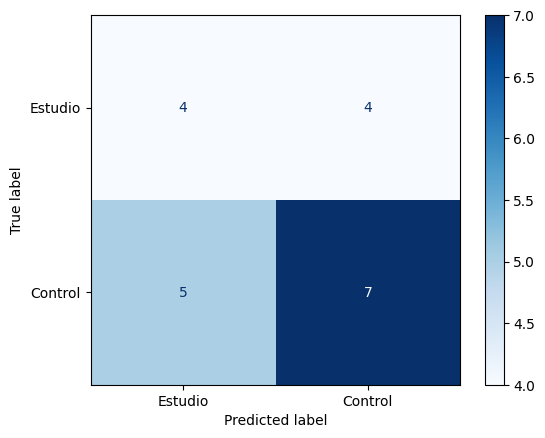

In [65]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['bglr'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [66]:
print(classification_report(y_true=y_test,y_pred=fit_models['bglr'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.64      0.58      0.61        12

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.56      0.55      0.55        20



In [69]:
score = fit_models['bglr'].score(X_test_scaled, y_test) # Calculamos el score


In [ ]:
fit_models['bglr'].best_estimator_.named_steps['bglr']

In [ ]:
beta_0 = fit_models['bglr'].intercept_ # El beta 0
beta_1 = fit_models['bglr'].coef_[0][0] # El coeficiente beta_1
beta_2 = fit_models['bglr'].coef_[0][1] # El coeficiente beta_2